In [ ]:
!pip3 install h2o --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=21f41028d63ae47a93d5be740a7b83da945b83bef0a9ae43d56c9663976b07c6
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o


In [ ]:
!pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the transaction data
df1 = pd.read_csv('/content/drive/MyDrive/Fraud Dataset/updated_fraud_transactions.csv')
df1.head()

,Transaction ID,Timestamp,Sender Account ID,Transaction Type,IN_OUT,Amount,Recipient Bank,Fraud
0,T00001,2023-08-14 08:37:07,10095,Transfer,In,4887.67,B0004,0
1,T00002,2023-12-04 12:54:11,10098,Transfer,In,2371.33,B00010,0
2,T00003,2023-07-09 23:16:11,10097,Credit,In,4733.44,B0008,0
3,T00004,2023-06-26 07:04:39,10039,Credit,In,1544.12,B0005,0
4,T00005,2023-09-28 02:40:56,10018,Debit,Out,3978.04,B0004,0


In [ ]:
#load customer data
df2 = pd.read_csv('/content/drive/MyDrive/Fraud Dataset/customer_dataset 1.csv')
df2.head()

,Customer ID,Name,Age,Location,Gender,Account Type,Device Count
0,10001,Nimal Fernando,61,Jaffna,Female,Savings,5
1,10002,Sunil Samarasinghe,60,Jaffna,Other,Current,3
2,10003,Ruwan Jayasinghe,67,Galle,Other,Savings,1
3,10004,Lakshan Perera,19,Anuradhapura,Female,Savings,5
4,10005,Ruwan Kumara,52,Ratnapura,Other,Current,4


In [ ]:
df = df1.merge(df2[['Customer ID', 'Device Count','Location','Account Type','Age']], left_on='Sender Account ID', right_on='Customer ID')
df.dtypes

,0
Transaction ID,object
Timestamp,object
Sender Account ID,int64
Transaction Type,object
IN_OUT,object
Amount,float64
Recipient Bank,object
Fraud,int64
Customer ID,int64
Device Count,int64


In [ ]:
# Encoding
df = pd.get_dummies(df, columns=['IN_OUT', 'Account Type', 'Transaction Type'], drop_first=True)
label_encoder = LabelEncoder()
df['Recipient Bank'] = label_encoder.fit_transform(df['Recipient Bank'])


In [ ]:
district_map = {
    'Colombo': 1,       # Western Province
    'Gampaha': 2,       # Western Province
    'Kalutara': 3,      # Western Province
    'Kandy': 4,         # Central Province
    'Matale': 5,        # Central Province
    'Nuwara Eliya': 6,  # Central Province
    'Galle': 7,         # Southern Province
    'Matara': 8,        # Southern Province
    'Hambantota': 9,    # Southern Province
    'Jaffna': 10,       # Northern Province
    'Kilinochchi': 11,  # Northern Province
    'Mannar': 12,       # Northern Province
    'Vavuniya': 13,     # Northern Province
    'Mullaitivu': 14,   # Northern Province
    'Trincomalee': 15,  # Eastern Province
    'Batticaloa': 16,   # Eastern Province
    'Ampara': 17,       # Eastern Province
    'Kurunegala': 18,   # North Western Province
    'Puttalam': 19,     # North Western Province
    'Anuradhapura': 20, # North Central Province
    'Polonnaruwa': 21,  # North Central Province
    'Badulla': 22,      # Uva Province
    'Monaragala': 23,   # Uva Province
    'Ratnapura': 24,    # Sabaragamuwa Province
    'Kegalle': 25       # Sabaragamuwa Province
}

df['Location'] = df['Location'].map(district_map)

In [ ]:
# Column Scaling
df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [ ]:
# Feature Engineering
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['weekend'] = df['Timestamp'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)


In [ ]:
# Monthly customer features
monthly_customer_features = df.groupby(['Customer ID', 'Year', 'Month']).agg(
    Monthly_Transaction_Count=('Transaction ID', 'count'),
    Monthly_Average_Transaction_Amount=('Amount', 'mean')
).reset_index()
df = df.merge(monthly_customer_features, on=['Customer ID', 'Year', 'Month'], how='left')
df['Transaction Amount Ratio'] = df['Amount'] / df['Monthly_Average_Transaction_Amount']

# Device Count Levels
df['Device Count Category'] = pd.cut(df['Device Count'], bins=[0, 3, 7, 11], labels=[1, 2, 3], right=True).astype(int)

# Time Since Last Transaction
df['Last_Transaction'] = df.groupby('Sender Account ID')['Timestamp'].shift(1)
df['Time_Since_Last_Transaction'] = (df['Timestamp'] - df['Last_Transaction']).dt.total_seconds() / 60


In [ ]:
# Drop unnecessary columns
df.drop(columns=['Transaction ID', 'Timestamp', 'Customer ID', 'Sender Account ID', 'Device Count', 'Last_Transaction'], inplace=True)


In [ ]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Amount                              100000 non-null  float64
 1   Recipient Bank                      100000 non-null  int64  
 2   Fraud                               100000 non-null  int64  
 3   Location                            86948 non-null   float64
 4   Age                                 100000 non-null  float64
 5   IN_OUT_Out                          100000 non-null  bool   
 6   Account Type_Fixed Deposit          100000 non-null  bool   
 7   Account Type_Savings                100000 non-null  bool   
 8   Transaction Type_Debit              100000 non-null  bool   
 9   Transaction Type_Payment            100000 non-null  bool   
 10  Transaction Type_Transfer           100000 non-null  bool   
 11  Year                       

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Step 2: Reshape the data to 2D array for the imputer
Location = df[['Location']]

# Step 3: Fit and transform the column
imputed_values = imputer.fit_transform(Location)

# Step 4: Assign the imputed values back to the DataFrame
df['Location'] = imputed_values

In [ ]:
# Handle missing values and prepare for modeling
df = df.dropna(subset=['Fraud'])
X = df.drop(columns=['Fraud'])
y = df['Fraud']


In [ ]:
# Data Balancing
smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)


In [ ]:
# Combine features and target
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)


In [ ]:
# Split the data
train_data, test_data = train_test_split(df_resampled, test_size=0.2, random_state=42)


In [ ]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl8jkxfj1
  JVM stdout: /tmp/tmpl8jkxfj1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpl8jkxfj1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_5cxyuc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Convert pandas DataFrames to H2O DataFrames
train = h2o.H2OFrame(train_data)
test = h2o.H2OFrame(test_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Identify predictors and response
x = train.columns
y = "Fraud"
x.remove(y)

In [ ]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()


In [ ]:
# Run AutoML for 10 minutes
aml = H2OAutoML(max_runtime_secs=600, seed=1)
aml.train(x=x, y=y, training_frame=train)


AutoML progress: |
09:29:52.503: _train param, Dropping bad and constant columns: [Year]

██████████████████
09:32:36.545: _train param, Dropping bad and constant columns: [Year]

████
09:33:15.210: _train param, Dropping bad and constant columns: [Year]

██████████████████████
09:36:54.633: _train param, Dropping unused columns: [Year]

█
09:37:03.665: _train param, Dropping bad and constant columns: [Year]

███
09:37:31.433: _train param, Dropping bad and constant columns: [Year]

███
09:37:57.597: _train param, Dropping bad and constant columns: [Year]

██
09:38:22.947: _train param, Dropping bad and constant columns: [Year]

███
09:38:47.456: _train param, Dropping bad and constant columns: [Year]

██
09:39:11.778: _train param, Dropping unused columns: [Year]

█
09:39:17.724: _train param, Dropping unused columns: [Year]

█
09:39:27.9: _train param, Dropping bad and constant columns: [Year]

█
09:39:32.928: _train param, Dropping bad and constant columns: [Year]


09:39:40.159: _t

key,value
Stacking strategy,cross_validation
Number of base models (used / total),2/3
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20241003_92952  0.997021  0.0661293  0.997607               0.0253408  0.138713  0.0192413
StackedEnsemble_AllModels_1_AutoML_1_20241003_92952     0.997008  0.0666049  0.997598               0.025464   0.138912  0.0192965
StackedEnsemble_BestOfFamily_2_AutoML_1_20241003_92952  0.997007  0.0666005  0.997597               0.0253929  0.138903  0.019294
StackedEnsemble_BestOfFamily_3_AutoML_1_20241003_92952  0.996976  0.0727018  0.997575               0.0254015  0.141258  0.0199539
GBM_1_AutoML_1_20241003_92952                           0.996965  0.0687206  0.997567               0.0254846  0.139915  0.0195763
XGBoost_1_AutoML_1_20241003_92952                       0.995937  0.0784321  0.996782               0.0295117  0.150297  0.0225891
XGBoost_2_AutoML_1_20241003_92952                       0.991826  0.131456   0.99364

In [ ]:
# Get the best model
best_model = aml.leader

In [ ]:
# Perform predictions
preds = best_model.predict(test)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [ ]:
# Get the predictions as a pandas DataFrame
preds_df = h2o.as_list(preds)


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
# Convert 'predict' column to integer type (0 or 1)
preds_df['predict'] = preds_df['predict'].astype(int)

In [ ]:
# Add probability columns to the predictions DataFrame
preds_df['probability_0'] = h2o.as_list(preds['p0'])
preds_df['probability_1'] = h2o.as_list(preds['p1'])


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
# Combine predictions with original test data
test_data_with_preds = test_data.reset_index(drop=True)
test_data_with_preds['predicted_fraud'] = preds_df['predict']
test_data_with_preds['fraud_probability'] = preds_df['probability_1']


In [ ]:
# Display the first few rows of the combined DataFrame
print("\nSample of Test Data with Predictions:")
print(test_data_with_preds.head())



Sample of Test Data with Predictions:
     Amount  Recipient Bank   Location       Age  IN_OUT_Out  \
0 -0.308139               0  22.177292  0.463879        True   
1  0.168835               4   8.000000  0.193548       False   
2  0.333568               4  15.000000  0.919355        True   
3  9.093479               3   4.346675  0.313621        True   
4 -1.063902               1  15.000000  0.935484       False   

   Account Type_Fixed Deposit  Account Type_Savings  Transaction Type_Debit  \
0                        True                  True                    True   
1                       False                  True                   False   
2                        True                 False                    True   
3                       False                  True                   False   
4                        True                 False                   False   

   Transaction Type_Payment  Transaction Type_Transfer  ...  Hour  weekend  \
0                     F

In [ ]:
test_data_with_preds

,Amount,Recipient Bank,Location,Age,IN_OUT_Out,Account Type_Fixed Deposit,Account Type_Savings,Transaction Type_Debit,Transaction Type_Payment,Transaction Type_Transfer,...,Hour,weekend,Monthly_Transaction_Count,Monthly_Average_Transaction_Amount,Transaction Amount Ratio,Device Count Category,Time_Since_Last_Transaction,Fraud,predicted_fraud,fraud_probability
0,-0.308139,0,22.177292,0.463879,True,True,True,True,False,True,...,5,0,87,0.110687,-0.815946,1,68534.038386,1,1,0.999934
1,0.168835,4,8.000000,0.193548,False,False,True,False,False,True,...,2,1,79,-0.027395,-6.163038,1,-155189.633333,0,0,0.038834
2,0.333568,4,15.000000,0.919355,True,True,False,True,False,False,...,9,0,74,0.112787,2.957499,2,294135.700000,0,0,0.025486
3,9.093479,3,4.346675,0.313621,True,False,True,False,False,True,...,17,1,86,0.144149,63.628350,2,124455.421426,1,1,0.999990
4,-1.063902,1,15.000000,0.935484,False,True,False,False,False,False,...,18,0,66,0.202555,-5.252420,1,204809.316667,0,0,0.031133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17873,0.142192,3,24.000000,0.322581,True,True,False,True,False,False,...,9,1,81,-0.121681,-1.168569,3,132117.766667,0,0,0.000217
17874,1.549494,0,8.004021,0.275037,False,False,True,False,False,False,...,0,0,106,0.014615,104.643992,2,149074.809396,1,1,0.999846
17875,-1.076441,4,8.000000,0.419355,True,True,False,False,False,True,...,7,0,93,-0.115805,9.295249,1,-9441.133333,0,0,0.302893
17876,-0.182759,0,4.000000,0.854839,False,True,False,False,False,True,...,10,0,83,0.011484,-15.914733,1,154099.100000,0,0,0.000655


In [ ]:
# Save the DataFrame to a CSV file
output_file = "test_data_with_predictions.csv"
test_data_with_preds.to_csv(output_file, index=False)
print(f"\nTest data with predictions has been saved to: {output_file}")


Test data with predictions has been saved to: test_data_with_predictions.csv


In [ ]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(test_data[y], preds_df['predict']))

print("\nConfusion Matrix:")
print(confusion_matrix(test_data[y], preds_df['predict']))



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8447
           1       0.98      0.97      0.98      9431

    accuracy                           0.98     17878
   macro avg       0.98      0.98      0.98     17878
weighted avg       0.98      0.98      0.98     17878


Confusion Matrix:
[[8289  158]
 [ 273 9158]]


In [ ]:
# Feature importance
varimp = best_model.varimp(use_pandas=True)
if varimp is not None:
    plt.figure(figsize=(10, 6))
    varimp.plot(kind='barh', x='variable', y='relative_importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model type.")

Feature importance not available for this model type.



Feature importance not available for this model type.

Top 10 features correlated with Fraud:
Fraud                                 1.000000
Transaction Type_Transfer             0.445601
Monthly_Average_Transaction_Amount    0.372325
Amount                                0.314892
Account Type_Fixed Deposit            0.291792
Account Type_Savings                  0.244211
IN_OUT_Out                            0.230898
Transaction Type_Debit                0.094410
Transaction Type_Payment              0.082242
Transaction Amount Ratio              0.048806
weekend                               0.000421
Name: Fraud, dtype: float64


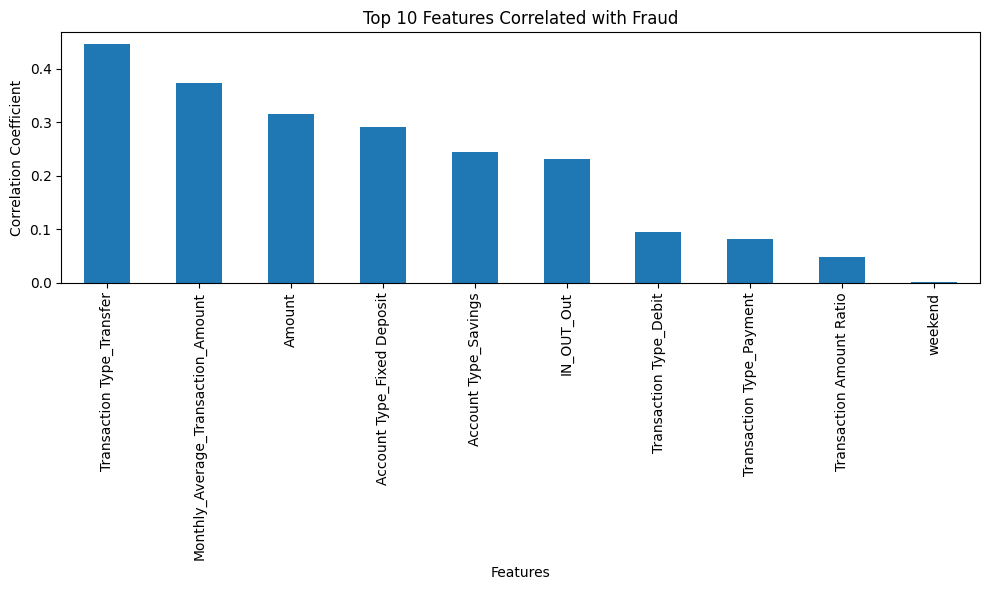

In [ ]:
# Check if variable importance is available
try:
    varimp = best_model.varimp(use_pandas=True)
    if varimp is not None and not varimp.empty:
        plt.figure(figsize=(10, 6))
        varimp.plot(kind='barh', x='variable', y='relative_importance')
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        raise ValueError("Variable importance is empty")
except:
    print("\nFeature importance not available for this model type.")

    # Alternative: Display correlation with target variable
    print("\nTop 10 features correlated with Fraud:")
    correlations = test_data.corr()['Fraud'].sort_values(ascending=False)
    print(correlations.head(11))  # 11 because 'Fraud' itself will be included

    # Visualize top correlations
    plt.figure(figsize=(10, 6))
    correlations.drop('Fraud').head(10).plot(kind='bar')
    plt.title('Top 10 Features Correlated with Fraud')
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()

In [ ]:
# Model performance metrics
print("\nModel Performance Metrics:")
perf = best_model.model_performance(test)
print(perf)



Model Performance Metrics:
ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.018394000525158622
RMSE: 0.13562448350190545
LogLoss: 0.06307027022453256
AUC: 0.997316681055704
AUCPR: 0.9977970331847343
Gini: 0.9946333621114081
Null degrees of freedom: 17877
Residual degrees of freedom: 17875
Null deviance: 24730.673185412696
Residual deviance: 2255.140582148386
AIC: 2261.140582148386

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.53775117726875
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      8313  134   0.0159   (134.0/8447.0)
1      293   9138  0.0311   (293.0/9431.0)
Total  8606  9272  0.0239   (427.0/17878.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.537751     0.977169  165
max f2                       0.216274     0.979264  254
max f0point5     

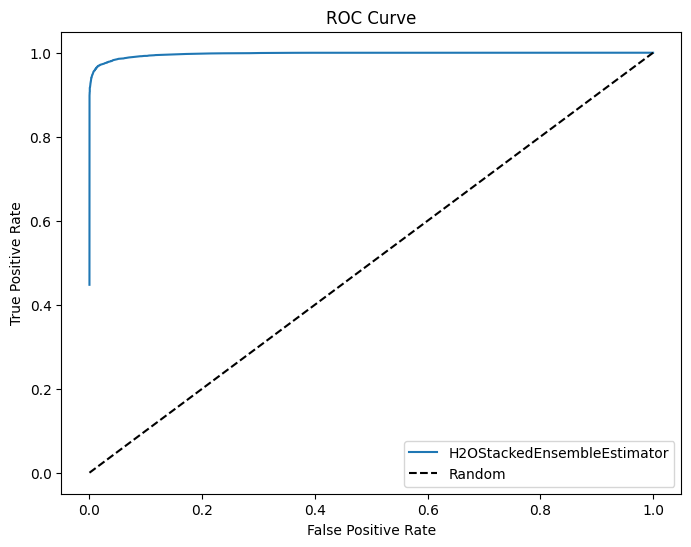

In [ ]:
# ROC curve
plt.figure(figsize=(8, 6))
model_name = type(best_model).__name__
plt.plot(perf.fprs, perf.tprs, label=model_name)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()